# Visualisations for Thesis

In [43]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# create uniform colour palette
palette ={"Radio Corporacion": "#dd8452","Canal14": "#4c72b0","Canal10": "#da8bc3",
          "regime": "#c44e52", "opposition": "#55a868"}
# set uniform figure size
sns.set(rc={'figure.figsize':(20,10)})
# set seaborne style
sns.set_theme(style = 'whitegrid', font_scale=1.5)

# set save location
figureloc = "/home/hennes/thesis/Figures/topics/"
dataloc = "/home/hennes/thesis/Data/"

In [3]:
# load data
with open(dataloc+"dataset_sentiment.pkl", "rb") as f:
    dfa = pickle.load(f)
    
# drop Radio 800
dfa = dfa.loc[dfa["page"] != "Radio 800"]

# keep only data from 2018
dfa = dfa.loc[dfa["year"] > 2017]

# transform date to datetime format
dfa['date'] = pd.to_datetime(dfa['date'], errors='coerce')

# create different date periods for aggregation
dfa["quarter"] = dfa.date.dt.to_period('Q')
dfa['quarter'] = dfa['quarter'].apply(lambda x: x.strftime('%Y-%m'))

dfa["semiannual"] = dfa.date.dt.to_period('2Q')
quarts = [["2022Q2", "2022Q1"],
["2021Q2", "2021Q1"],
["2021Q4", "2021Q3"],
["2020Q2", "2020Q1"],
["2020Q4", "2020Q3"],
["2019Q2", "2019Q1"],
["2019Q4", "2019Q3"],
["2018Q2", "2018Q1"],
["2018Q4", "2018Q3"],
["2017Q2", "2017Q1"],
["2017Q4", "2017Q3"],
["2016Q2", "2016Q1"],
["2016Q4", "2016Q3"],]

for pair in quarts:
    dfa.loc[dfa["semiannual"] == pair[0], "semiannual"] = pair[1]

dfa['semiannual'] = dfa['semiannual'].apply(lambda x: x.strftime('%Y-%m'))
    
dfa["year"] = dfa.date.dt.to_period('Y')
dfa['year'] = dfa['year'].apply(lambda x: x.strftime('%Y'))
dfa['year_month'] = dfa['date'].apply(lambda x: x.strftime('%Y-%m'))

repl_dict = {
    "Canal10":"Canal10",
     'Canal4':"regime",
     'Radio la Primerisima':"regime",
     'Confidencial':"opposition",
     'Canal6':"regime",
     'Canal14':"Canal14",
     '100% Noticias':"opposition",
     'Canal13':"regime",
     'Canal2':"regime",
     'Radio Nicaragua':"regime",
     'Radio Corporacion':"Radio Corporacion"
}

# create categories
dfa["position"] = dfa["page"].replace(repl_dict)

In [50]:
# change this variable to desired aggregation level
agg_level = "year"
dfa["date"] = dfa[agg_level]
dfa["date"] = pd.to_datetime(dfa["date"])

# events to mark on plot
events = [[pd.to_datetime("2018-04-18"), "beginning of\nprotests"],
         [pd.to_datetime("2020-10-26"), "passing of\ncybercrime law"],
         [pd.to_datetime("2021-06-20"), "series of journalist\njailings and raids\non newsrooms"],
         [pd.to_datetime("2018-12-15"), "occupation of\noffices of\nConfidencial and\n 100% Noticias"],
         [pd.to_datetime("2019-09-27"), "closure of\nnational newspaper\nEl Nuevo Diario"]]

## Polarity and Independence Visualisation

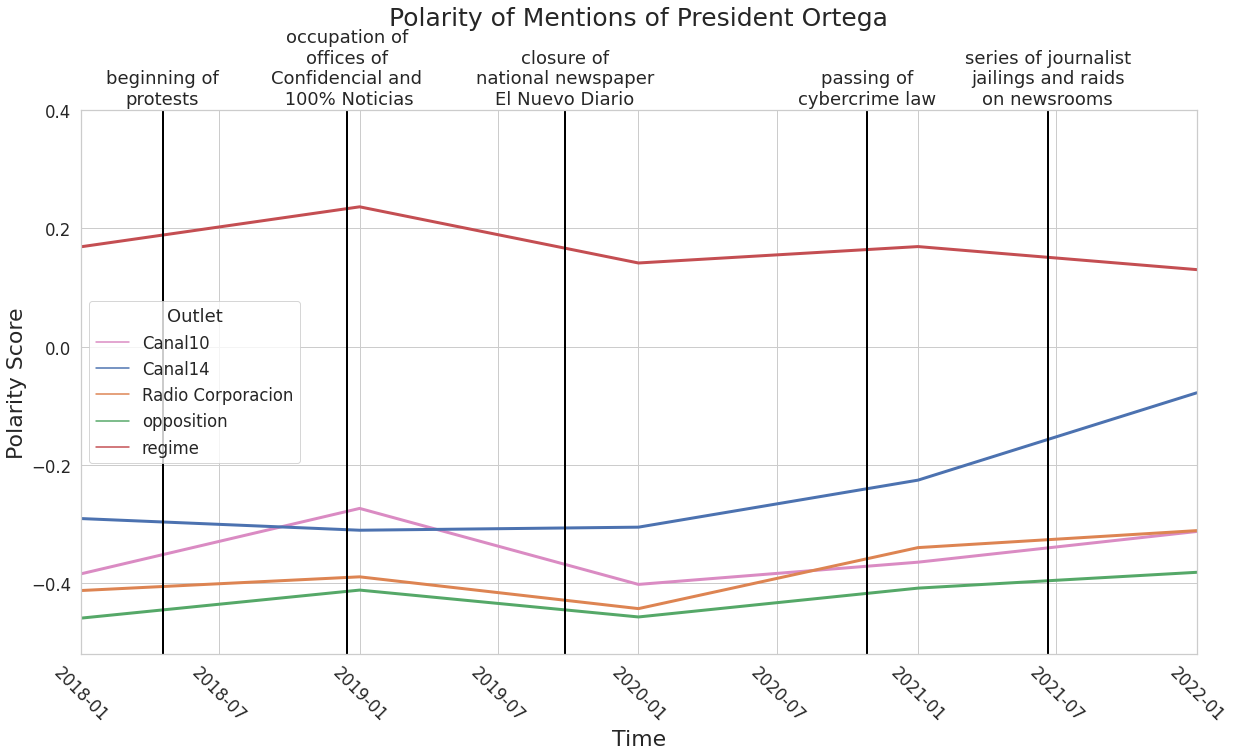

In [51]:
# create aggregated overview of sentiment per position and year-quarter
df_agg = (dfa.groupby(["position", "date"])["sentiment"]
 .value_counts(normalize=True)
 .rename("proportion")
 .reset_index())

# create polarity variable
df_agg.loc[df_agg["sentiment"] == "NEU", "polarity"] = 0
df_agg.loc[df_agg["sentiment"] == "POS", "polarity"] = df_agg["proportion"]
df_agg.loc[df_agg["sentiment"] == "NEG", "polarity"] = df_agg["proportion"]*(-1)

# create polarity aggregated data
df_pol = df_agg.groupby(["position", "date"]).agg({"polarity":np.sum}).reset_index()

data = df_pol

# exclude Canal10 and date in which C14 has no obs depending on agg level
if agg_level == "quarter":
    # activate following line when using quarterly aggregation
    data = data.loc[(data["position"] != "Canal10")&(data["date"] != "2018-03")]
elif agg_level == "semiannual":
    # activate following line when using semiannual aggregation
    data = data.loc[(data["position"] != "Canal10")]

# create lineplot
sns.lineplot(data = data, x="date", y="polarity", hue="position",
             palette = palette, linewidth = 3)

# add event lines and annotations
for x in range(len(events)):
            plt.axvline(events[x][0], ymax = 1, linewidth=2, color = "black")
            plt.annotate(events[x][1], xy=(events[x][0], 0.41), ha='center',
                        annotation_clip=False)
            
# set plot title
plt.title("Polarity of Mentions of President Ortega", fontsize = 25, pad = 85)
# rotate x-ticks by 315 degrees
plt.xticks(rotation=315)
# set x axis limits
if agg_level == "year":
    plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2022-01-01"))
else:
    plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2022-08-30"))
# set y axis limits
plt.ylim(-0.52, 0.4)
# set axis names
plt.xlabel("Time", fontsize = 22)
plt.ylabel("Polarity Score", fontsize = 22)
plt.legend(title = "Outlet")
# save figure
plt.savefig(figureloc+f'polarity_{agg_level}.png', bbox_inches="tight")

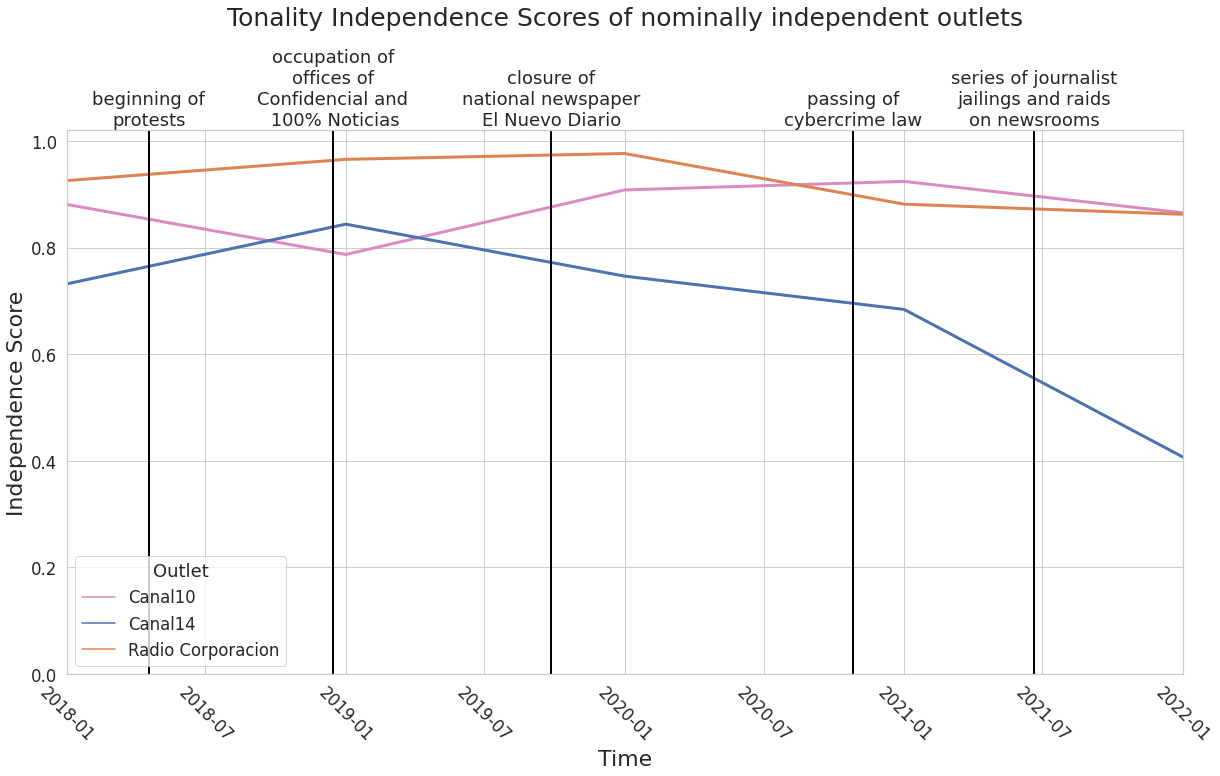

In [52]:
# create quarterly independence score visualisations

# create table to see how many mentions per outlet per year
df_can = pd.pivot(df_pol, index = "date", columns = "position", values = "polarity")

# create independence scores
df_can["Canal10"] = ((df_can["Canal10"]-df_can["regime"])/(df_can["opposition"]-df_can["regime"])).clip(0, 1)
df_can["Canal14"] = ((df_can["Canal14"]-df_can["regime"])/(df_can["opposition"]-df_can["regime"])).clip(0, 1)
df_can["Radio Corporacion"] = ((df_can["Radio Corporacion"]-df_can["regime"])/(df_can["opposition"]-df_can["regime"])).clip(0, 1)

# melt back to long format
df_ind = pd.melt(df_can.reset_index(), id_vars=['date'],
        value_vars=['Canal10', "Canal14", "Radio Corporacion"],
       value_name = "independence score")

data = df_ind 

# exclude Canal10 and date in which C14 has no obs depending on agg level
if agg_level == "quarter":
    # activate following line when using quarterly aggregation
    data = data.loc[(data["position"] != "Canal10")&(data["date"] != "2018-03")]
elif agg_level == "semiannual":
    # activate following line when using semiannual aggregation
    data = data.loc[(data["position"] != "Canal10")]

# create lineplot
sns.lineplot(data = data, x="date", y="independence score", hue="position",
             palette = palette, linewidth = 3)

# add event lines and annotations
for x in range(len(events)):
    plt.axvline(events[x][0], ymax = 1, linewidth=2, color = "black")
    plt.annotate(events[x][1], xy=(events[x][0], 1.03), ha='center', annotation_clip=False)

# set plot title
plt.title("Tonality Independence Scores of nominally independent outlets",
          fontsize = 25, pad = 105)
# set axis limits
plt.ylim(0, 1.02)
if agg_level == "year":
    plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2022-01-01"))
else:
    plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2022-08-30"))# rotate x axis ticks by 315 degrees
plt.xticks(rotation=315)
# label axes 
plt.xlabel("Time", fontsize = 22)
plt.ylabel("Independence Score", fontsize = 22)
plt.legend(title = "Outlet")
# save plot
plt.savefig(figureloc+f'tonality_independence_{agg_level}.png', bbox_inches="tight")

## create polynomial viz

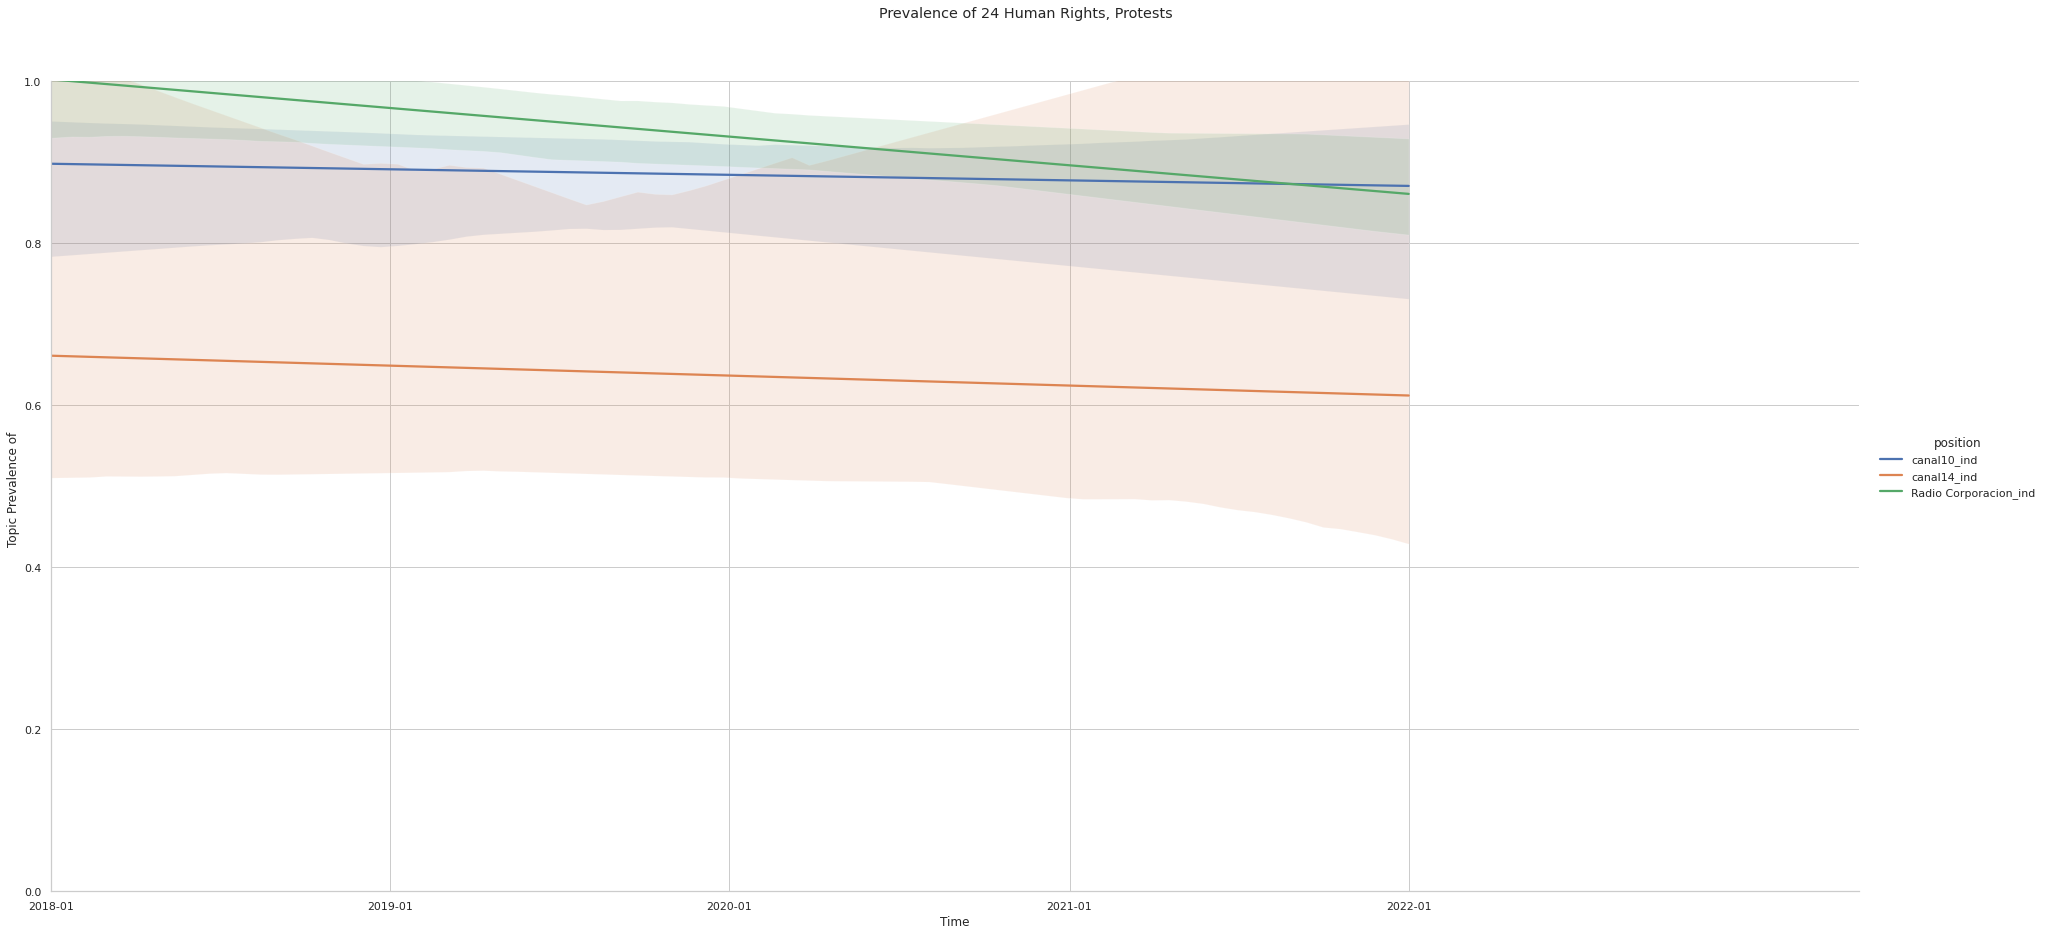

In [32]:
# create float representation of date
df_ind["date"] = pd.to_datetime(df_ind["date"])

df_ind["days"] = df_ind["date"].apply(lambda x: (x.to_pydatetime() - datetime.datetime(2018,1,1)).days)

ticks = [0, 365, 730, 1096, 1461]
dates = [df_ind.loc[df_ind["days"] == x, "date"].min().to_pydatetime().strftime("%Y-%m") for x in ticks]

data = df_ind
figure = sns.lmplot(data = data, x= "days", order = 1,
           y= "independence score", hue = "position",
          scatter = False, height=13, aspect= 2)
# control x and y limits
plt.ylim(0, 1)
plt.xlim(0, 1946)

for ax in figure.axes.flat:
    ax.set_xticks(ticks)
    ax.set_xticklabels(dates)
    
figure.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
figure.fig.suptitle('Prevalence of 24 Human Rights, Protests')
figure.set(xlabel = "Time", ylabel = f"Topic Prevalence of ")

plt.show()